In [103]:
import networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score

%matplotlib inline

In [13]:
graph = nx.read_gml('network.gml')

# Network Summary
* Network source
* Node attributes
* size, order

# Visualizaiton

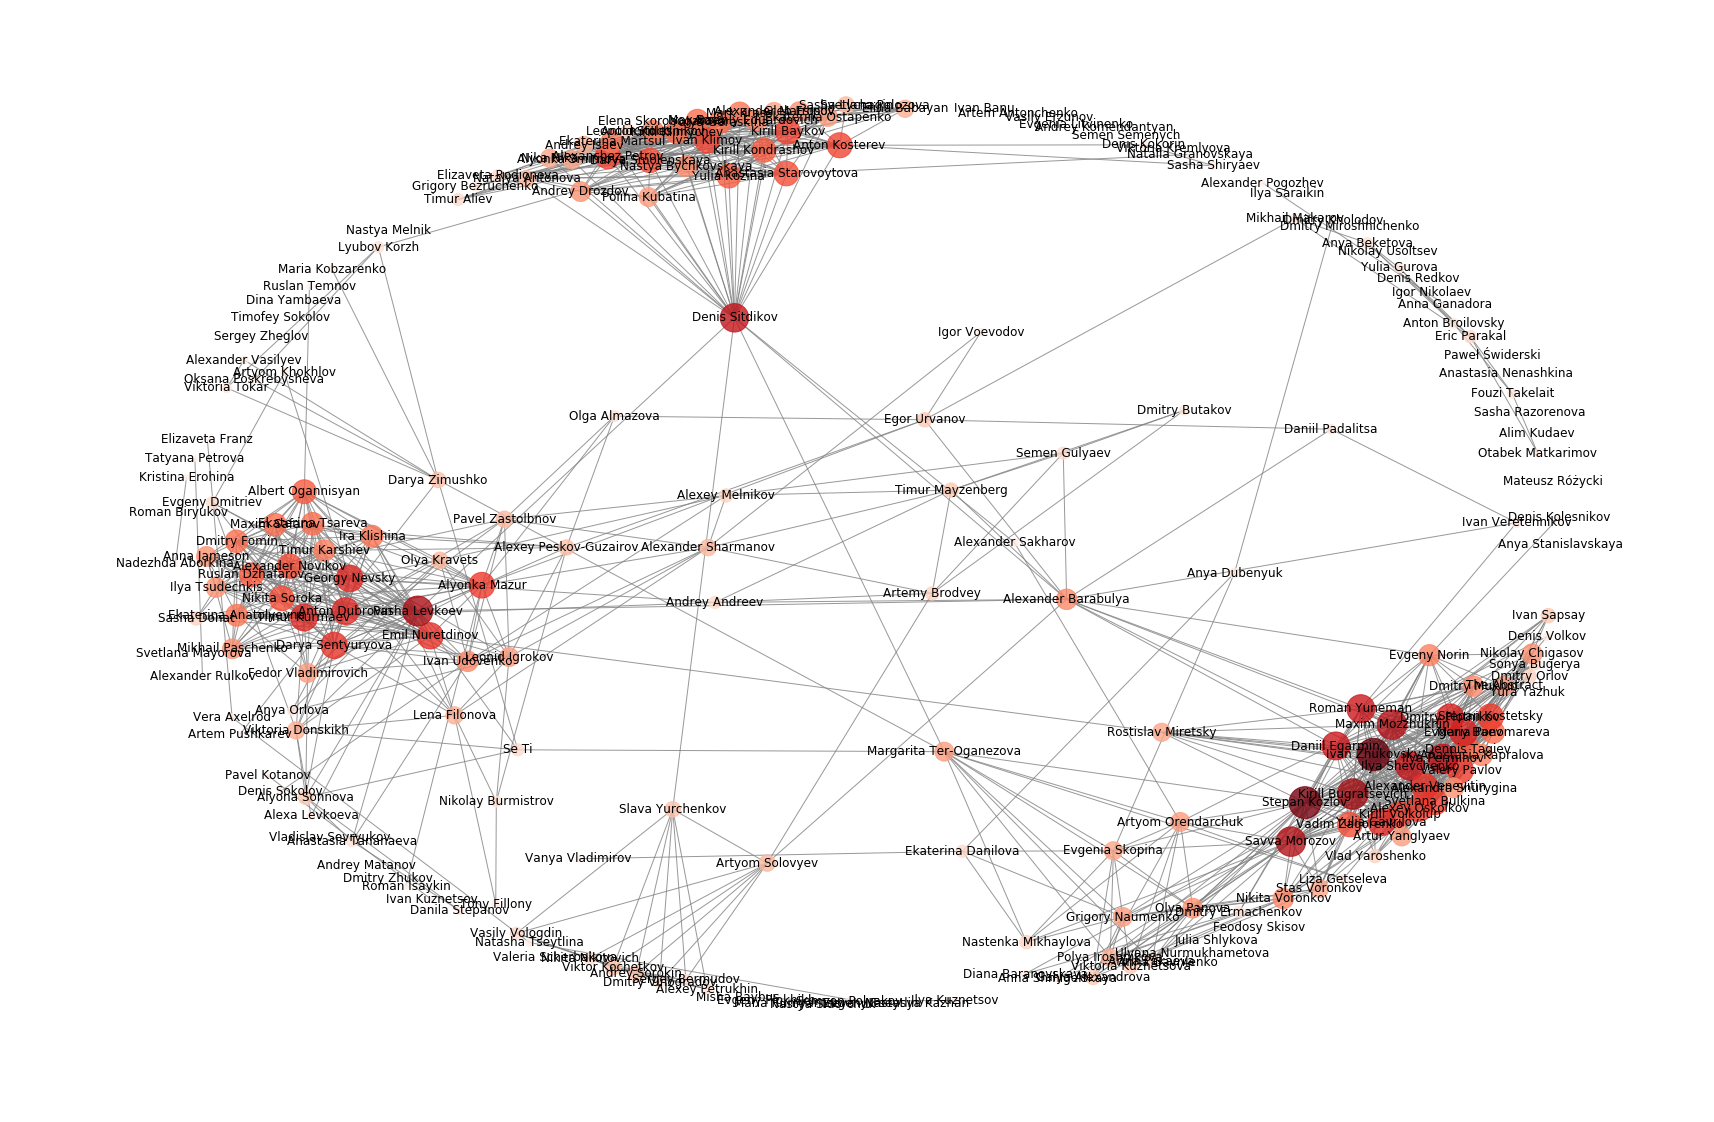

In [46]:
degree = nx.degree(graph)


subgraph = graph

degree = nx.degree(subgraph)
labels = nx.get_node_attributes(subgraph, 'full_name')

plt.figure(1, figsize=(30,20))
plt.axis('off')
pos = nx.spring_layout(subgraph, k=1.5/np.sqrt(subgraph.order()))
nx.draw_networkx(subgraph,
                 pos=pos,
                 node_size = [d*30 for k, d in degree.items()],
                 node_color=degree.values(),
                 font_size=12,
                 cmap=plt.cm.Reds,
                 with_labels=True,
                 labels=labels,
                 edge_color='grey',
                 alpha=0.8)
plt.show()

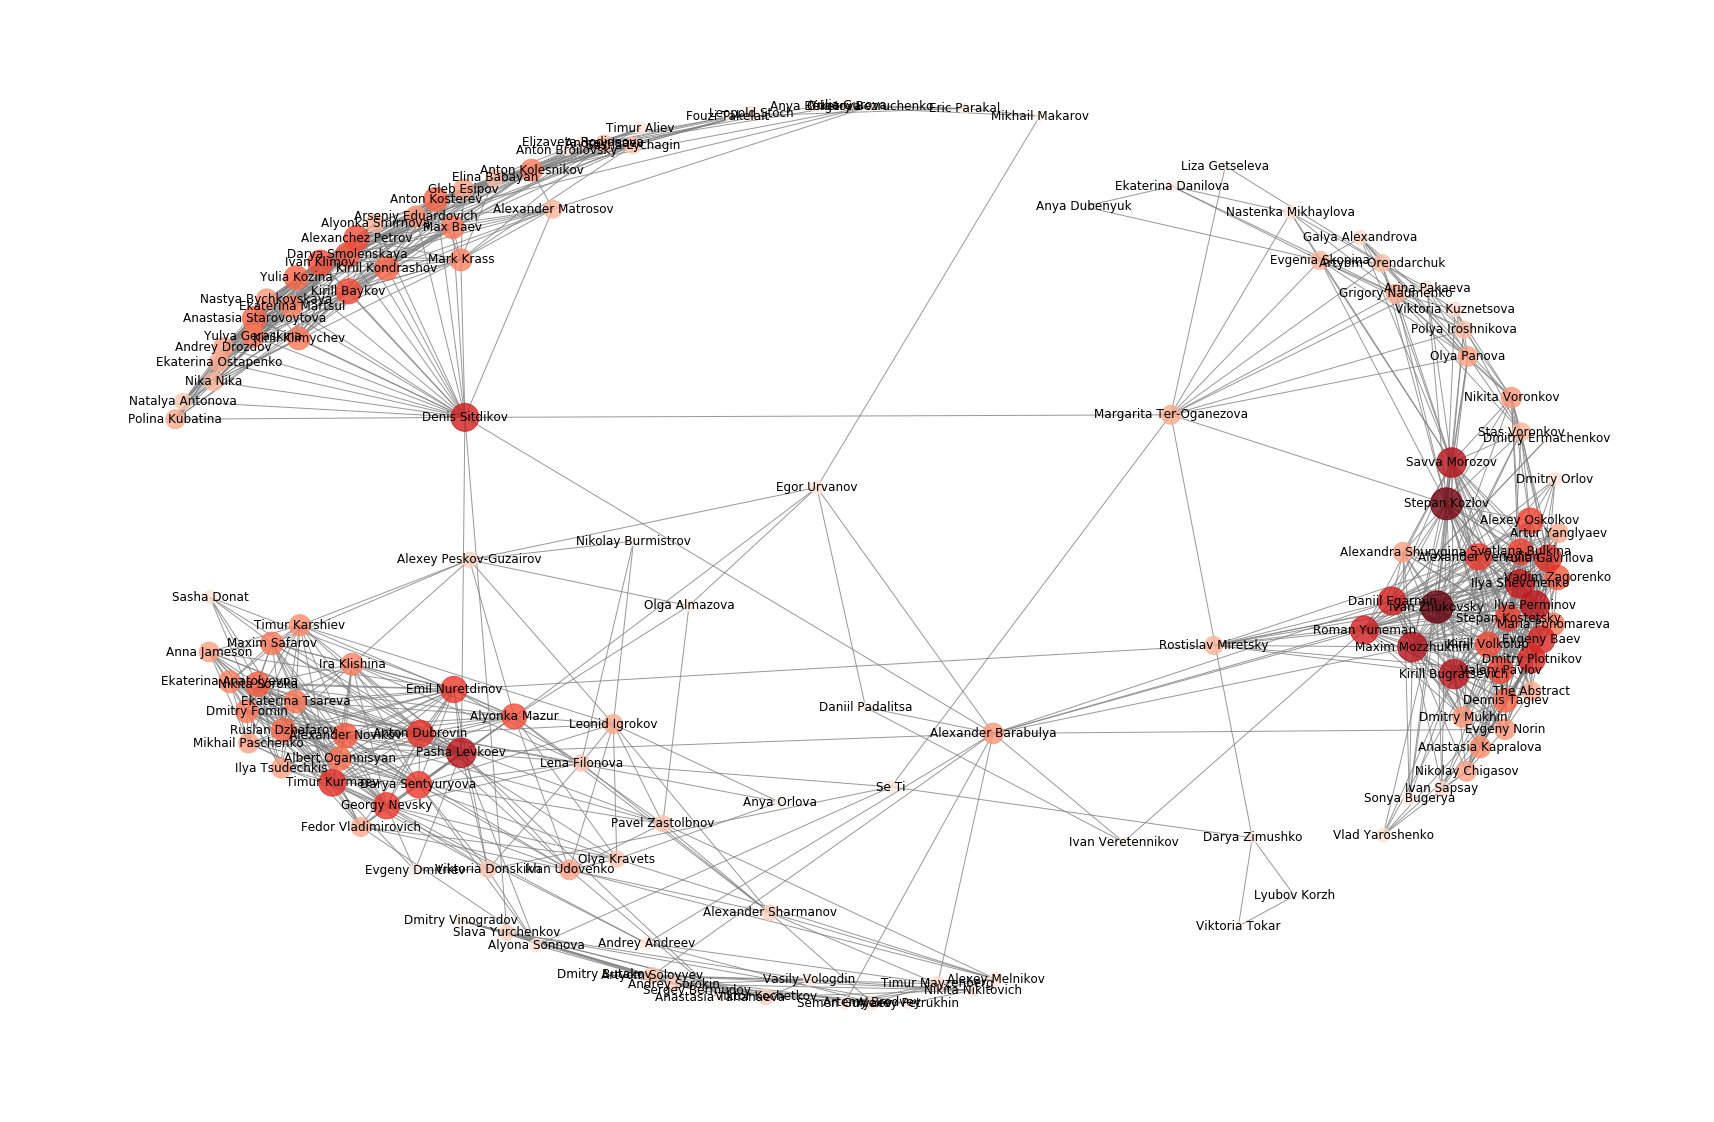

In [79]:
degree = nx.degree(graph)


filtered_nodes = [k for k, v in degree.items() if v > 2]
subgraph = nx.subgraph(graph, filtered_nodes)

degree = nx.degree(subgraph)
labels = nx.get_node_attributes(subgraph, 'full_name')

plt.figure(1, figsize=(30,20))
plt.axis('off')
pos = nx.spring_layout(subgraph, k=1.5/np.sqrt(subgraph.order()))
nx.draw_networkx(subgraph,
                 pos=pos,
                 node_size = [d*30 for k, d in degree.items()],
                 node_color=degree.values(),
                 font_size=12,
                 cmap=plt.cm.Reds,
                 with_labels=True,
                 labels=labels,
                 edge_color='grey',
                 alpha=0.8)
plt.show()

In [15]:
# Investigate degree distribution
def degree_pdf(graph):
    degree = pd.Series(graph.degree())
    degree = degree.sort_values()
    vcounts = degree.value_counts()
    
    degree_keys = pd.Series(vcounts.index).sort_values().values
    s = vcounts.sum()
    pdf=(vcounts/s)[degree_keys]
    
    return degree_keys, pdf

def plot_pdf(graph):
    degree_keys, pdf = degree_pdf(graph)
    plt.plot(degree_keys, pdf,'r')
    plt.title('Node degree PDF')
    plt.xlabel('$k$')
    plt.ylabel('$p(k)$')

def degree_cdf(graph):
    degree_keys, pdf = degree_pdf(graph)
    cdf = pdf.cumsum()
    
    return degree_keys, cdf

def plot_cdf(graph):
    degree_keys, cdf = degree_cdf(graph)
    plt.plot(degree_keys, cdf,'r')
    plt.title('Node degree CDF')
    plt.xlabel('$k$')
    plt.ylabel('$cdf(k)$')
    
def fit_log_log(degree_vals):
    x_est = np.log(range(1, len(degree_vals)+1))
    y_est = np.log(degree_vals)
    s = len(x_est)

    X = np.vstack([np.ones(s), x_est]).T
    Beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_est)

    a_linreg = -Beta[1]
    c_linreg = Beta[0]
    
    idx = np.argsort(x_est)
    yt = X[idx,:].dot(Beta)
    xt = X[idx,1]
    
    plt.plot(x_est, y_est, '.')
    plt.plot(xt, yt, '-')
    
    print 'R squared:', r2_score(yt, y_est)
    mse = (np.square(yt - y_est)).mean()
    print 'MSE', mse

    return a_linreg, c_linreg

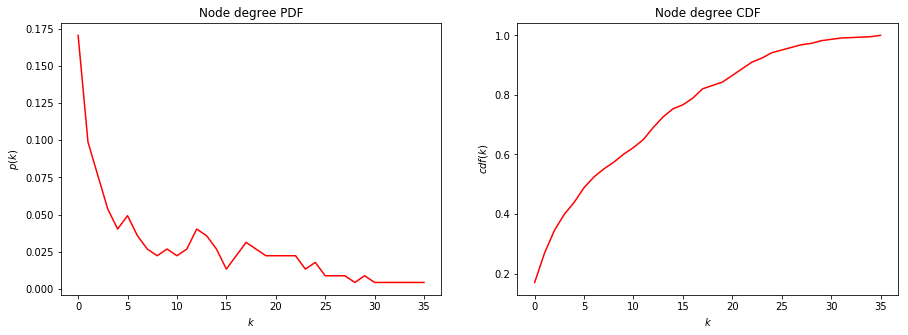

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plot_pdf(graph)
plt.subplot(1,2,2)
plot_cdf(graph)
plt.show()

Well this is some kind of powerlaw

R squared: 0.7151785257378536
MSE 0.1821073540856134


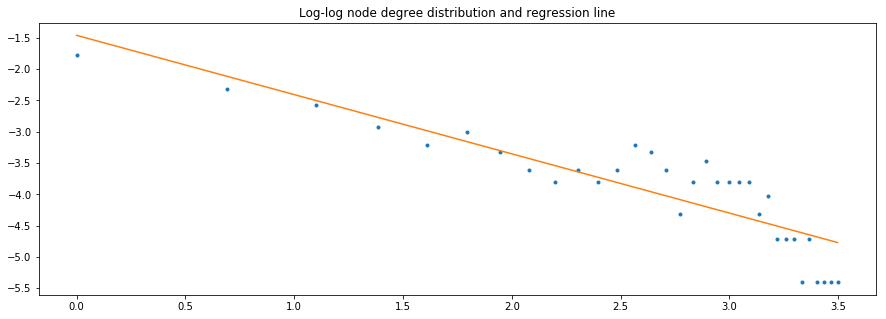

Estimated alpha 0.9459743462148557
Estimated C -1.4619462859731185


In [20]:
degree_keys, pdf =  degree_pdf(graph)
plt.figure(figsize=(15, 5))
plt.title('Log-log node degree distribution and regression line')
alpha, C= fit_log_log(pdf)
plt.show()
print 'Estimated alpha', alpha
print 'Estimated C', C

In [25]:
comp = next(nx.connected_component_subgraphs(graph))
print 'Diameter', nx.diameter(comp)
print 'Clustering coefficient', nx.average_clustering(graph)

Diameter 9
Clustering coefficient 0.450680285883


# Structural analysis

In [80]:
def draw_centralities(graph, measures, pos=None, k_mult=1.5):
    size_mult = 8000
    
    labels = nx.get_node_attributes(graph, 'full_name')
    
    plt.axis('off')
    pos = pos or nx.spring_layout(graph, k=k_mult/np.sqrt(graph.order()))
    nx.draw_networkx(graph,
                     pos=pos,
                     node_size = [d*size_mult for k, d in measures.items()],
                     node_color=measures.values(),
                     font_size=14,
                     cmap=plt.cm.Reds,
                     with_labels=True,
                     labels=labels,
                     edge_color='grey',
                     alpha=0.8)
    plt.show()

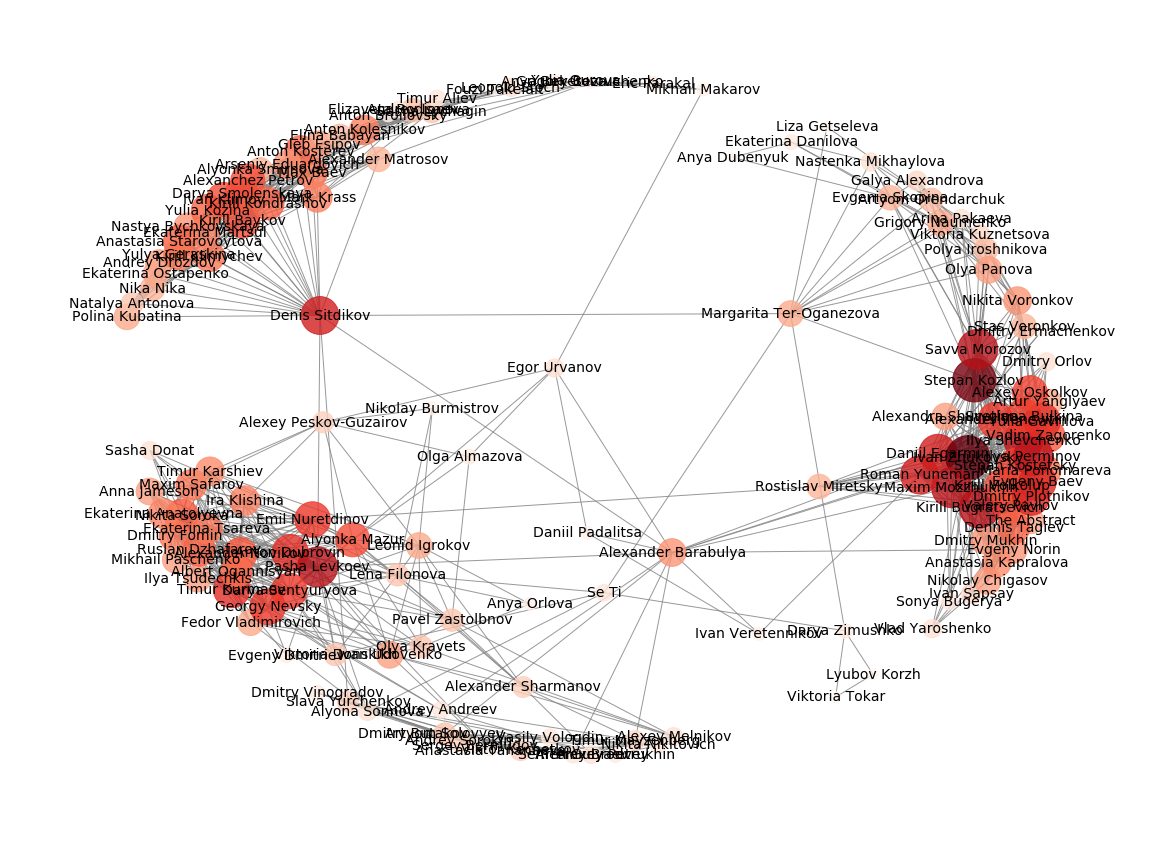

In [82]:
# Degree centrality
dc = nx.degree_centrality(subgraph)
plt.figure(1, figsize=(20,15))
draw_centralities(subgraph, dc, pos=pos)

In [91]:
def get_top_subgraph(graph, measures, quantile=0.5):
    dcs = pd.Series(measures)
    mask = dcs > dcs.quantile(quantile)
    nodes = pd.Series(subgraph.nodes())
    nodes.index = mask.index
    subgraph_nodes = nodes.ix[mask]
    subgraph_dcs = dcs.ix[mask]
    subgraph_top = nx.subgraph(graph, subgraph_nodes)
    return subgraph_top

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


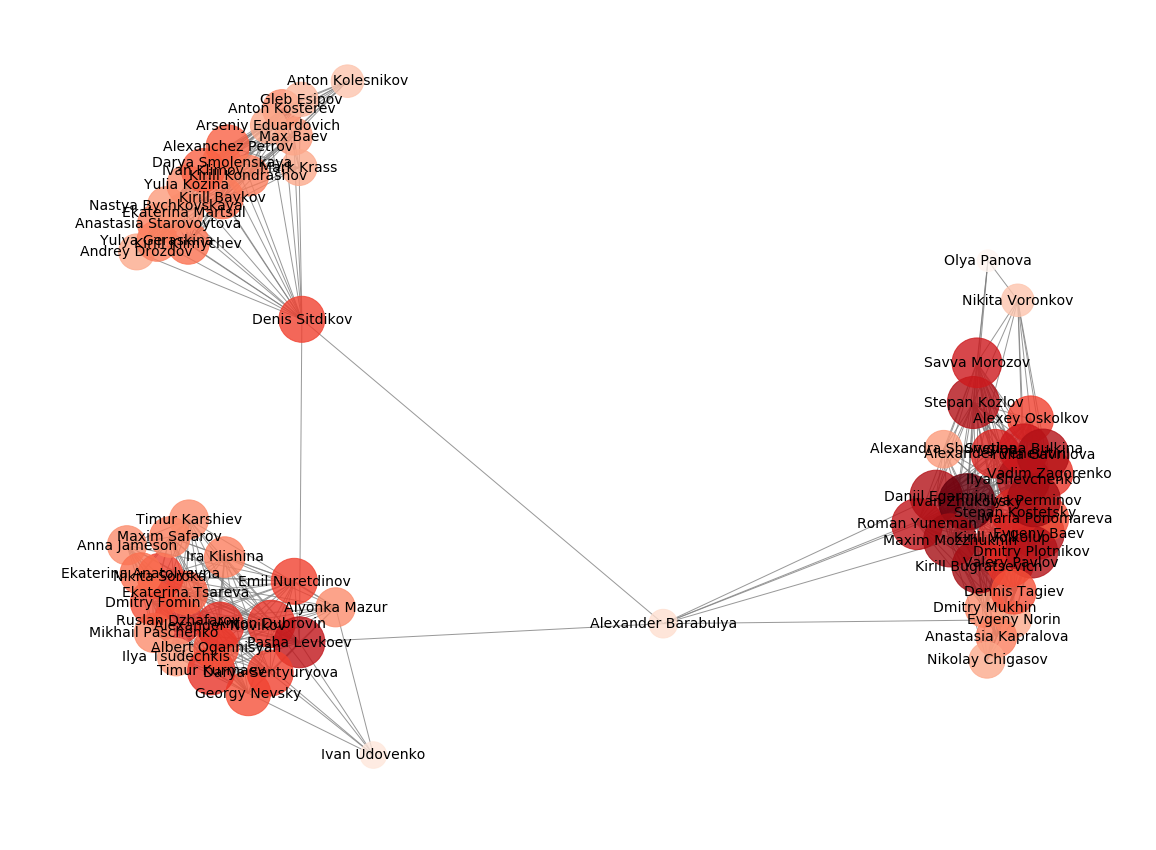

In [84]:
subgraph_top = get_top_subgraph(subgraph, dc)

plt.figure(1, figsize=(20,15))
draw_centralities(subgraph_top, nx.degree_centrality(subgraph_top), k_mult=3, pos=pos)

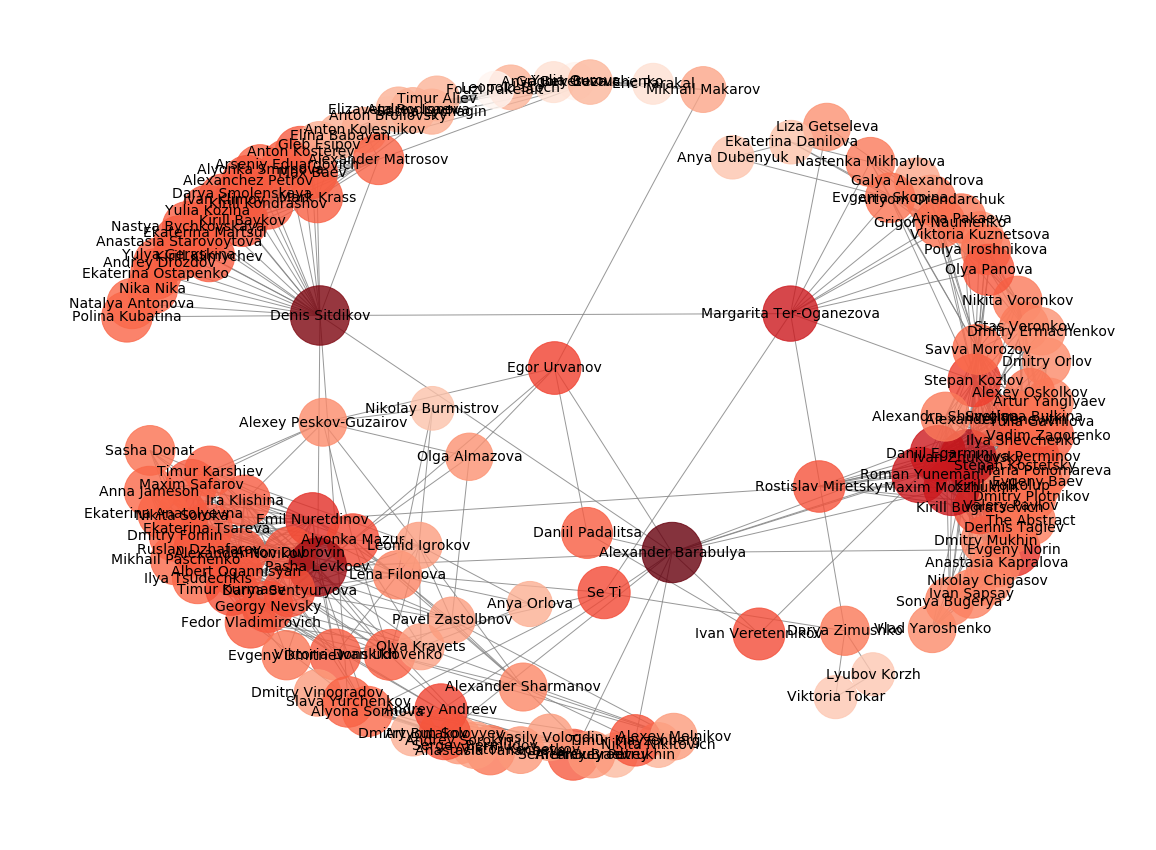

In [85]:
# Closeness centrality
cm = nx.closeness_centrality(subgraph)
plt.figure(1, figsize=(20,15))
draw_centralities(subgraph, cm, pos=pos)

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


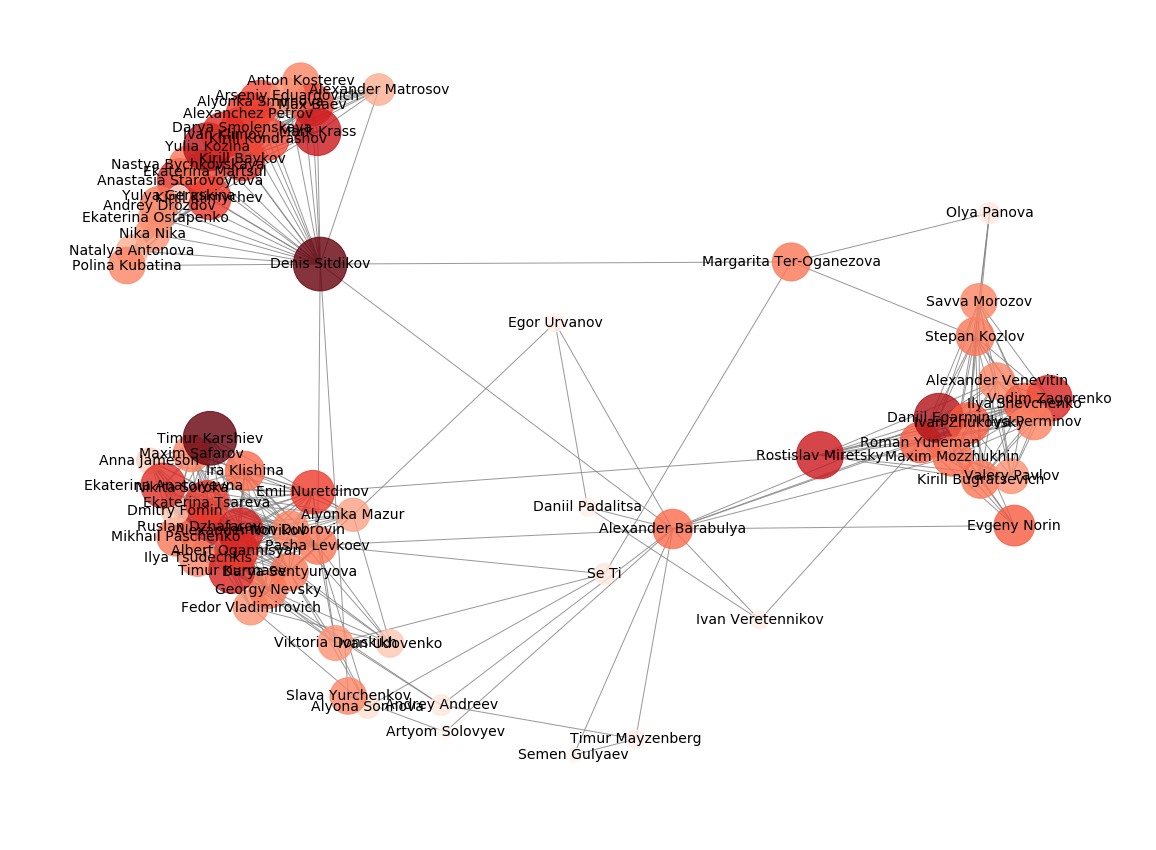

In [86]:
subgraph_top = get_top_subgraph(subgraph, cm)

plt.figure(1, figsize=(20,15))
draw_centralities(subgraph_top, nx.degree_centrality(subgraph_top), k_mult=3, pos=pos)

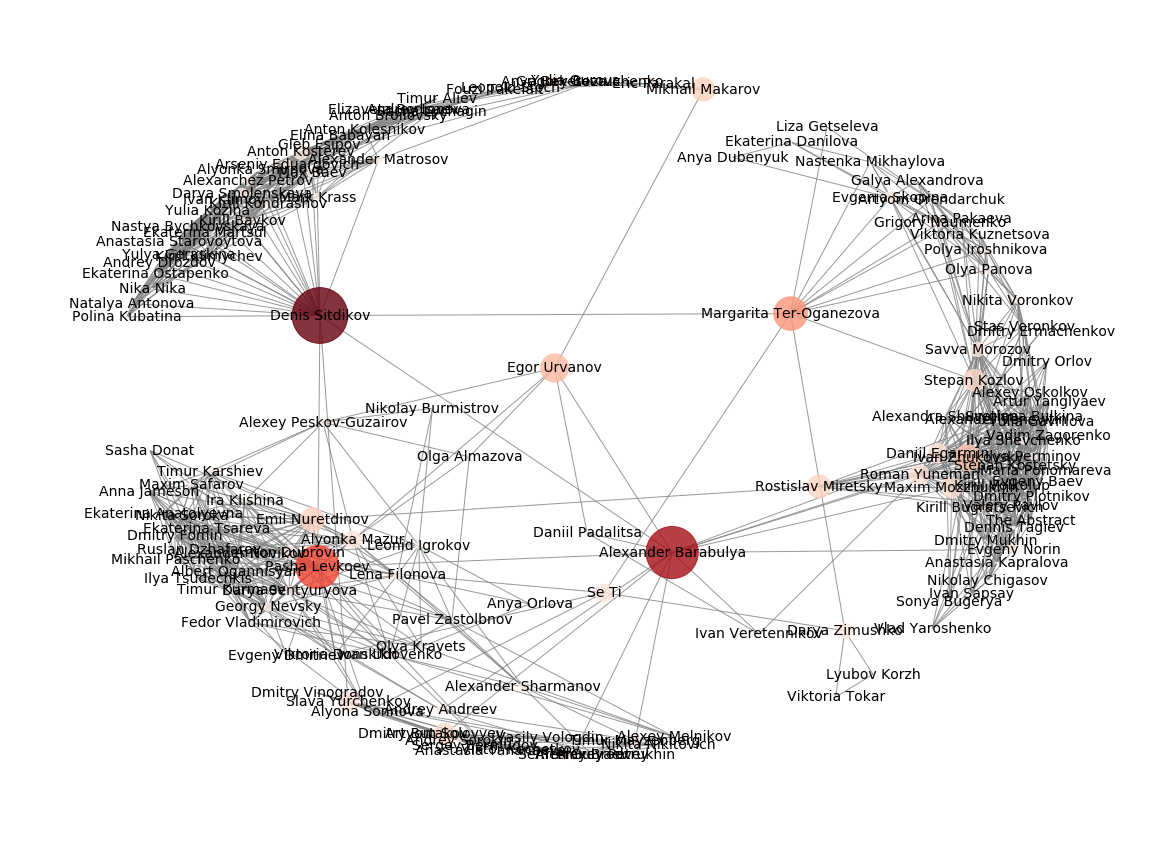

In [87]:
bc = nx.betweenness_centrality(subgraph)
plt.figure(1, figsize=(20,15))
draw_centralities(subgraph, bc, pos=pos)

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


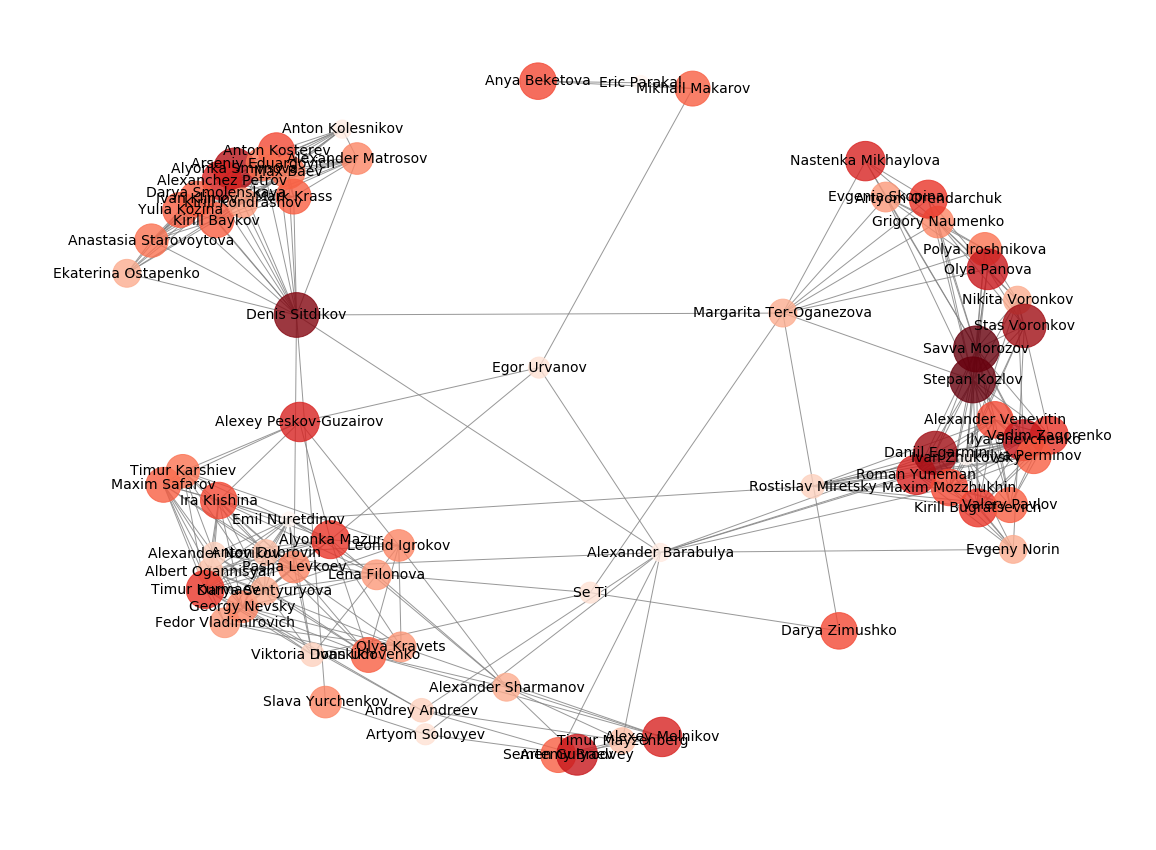

In [94]:
subgraph_top = get_top_subgraph(subgraph, bc, quantile=0.5)

plt.figure(1, figsize=(20,15))
draw_centralities(subgraph_top, nx.degree_centrality(subgraph_top), k_mult=3, pos=pos)

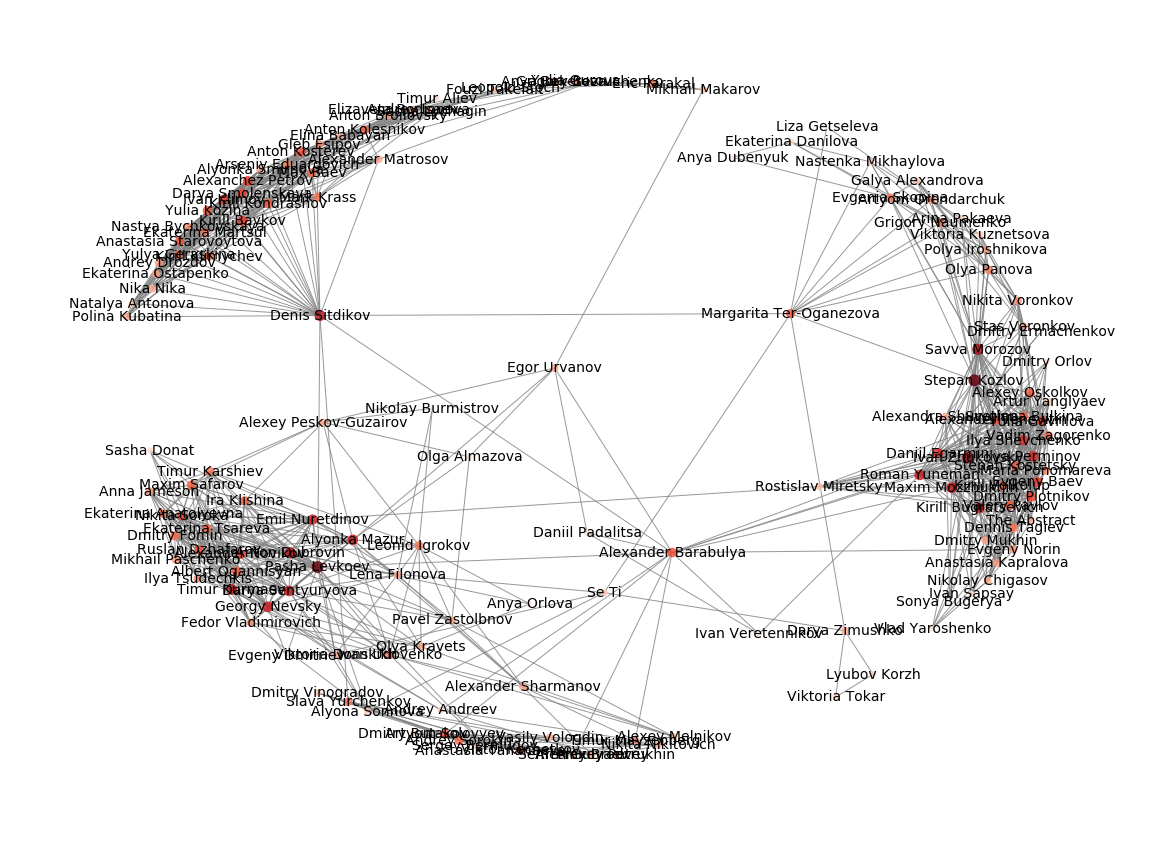

In [95]:
pr = nx.pagerank(subgraph)
plt.figure(1, figsize=(20,15))
draw_centralities(subgraph, pr, pos=pos)

/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/boris/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


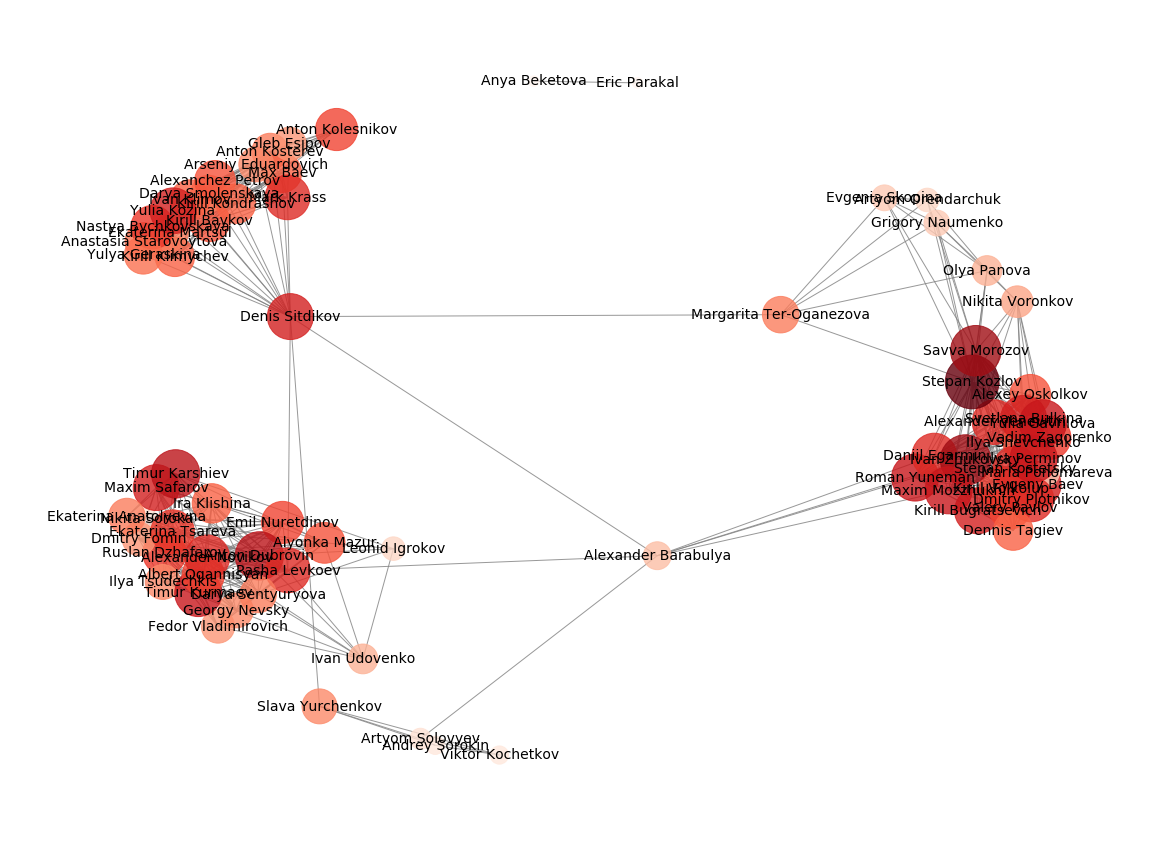

In [98]:
subgraph_top = get_top_subgraph(subgraph, pr, quantile=0.5)

plt.figure(1, figsize=(20,15))
draw_centralities(subgraph_top, nx.degree_centrality(subgraph_top), k_mult=3, pos=pos)

In [99]:
## Assortative mixing

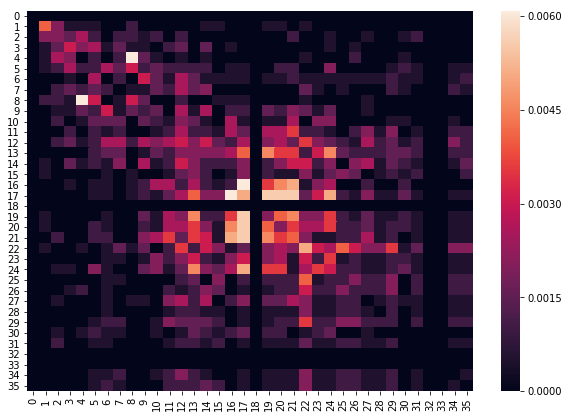

Node degree assortativity 0.30554900827462605


In [119]:
mixing_matrix = nx.degree_mixing_matrix(graph)
plt.figure(1, figsize=(10,7))
sns.heatmap(mixing_matrix)
plt.show()
print 'Node degree assortativity', nx.degree_assortativity_coefficient(graph)

In [120]:
graph.node[0].keys()

['label', 'bdate', 'id', 'full_name', 'sex']

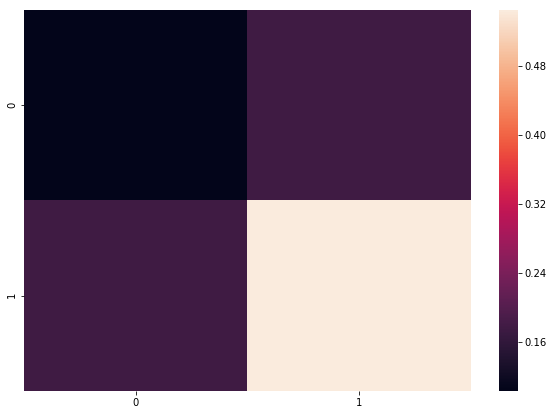

Node degree assortativity 0.125697527335


In [121]:
mixing_matrix = nx.attribute_mixing_matrix(graph, 'sex')
plt.figure(1, figsize=(10,7))
sns.heatmap(mixing_matrix)
plt.show()
print 'Node degree assortativity', nx.attribute_assortativity_coefficient(graph, 'sex')